# Sprint 深層学習スクラッチ 畳み込みニューラルネットワーク1

In [1]:
import numpy as np
from copy import deepcopy
import time
import matplotlib.pyplot as plt
%matplotlib inline

## 1.このSprintについて
### Sprintの目的
- スクラッチを通してCNNの基礎を理解する

### どのように学ぶか
スクラッチで1次元用畳み込みニューラルネットワークを実装した後、学習と検証を行なっていきます。

## 2.1次元の畳み込みニューラルネットワークスクラッチ

**畳み込みニューラルネットワーク（CNN）** のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。

このSprintでは1次元の **畳み込み層** を作成し、畳み込みの基礎を理解することを目指します。次のSprintでは2次元畳み込み層とプーリング層を作成することで、一般的に画像に対して利用されるCNNを完成させます。

クラスの名前はScratch1dCNNClassifierとしてください。クラスの構造などは前のSprintで作成したScratchDeepNeuralNetrowkClassifierを参考にしてください。

### 1次元畳み込み層とは
CNNでは画像に対しての2次元畳み込み層が定番ですが、ここでは理解しやすくするためにまずは1次元畳み込み層を実装します。1次元畳み込みは実用上は自然言語や波形データなどの 系列データ で使われることが多いです。

畳み込みは任意の次元に対して考えることができ、立体データに対しての3次元畳み込みまではフレームワークで一般的に用意されています。

### データセットの用意
検証には引き続きMNISTデータセットを使用します。1次元畳み込みでは全結合のニューラルネットワークと同様に平滑化されたものを入力します。

In [2]:
# MNISTデータ　ロード
from tensorflow.keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# 平滑化
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
# 前処理
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


### 適当なテストデータを作る¶
1dCNNは多くの場合で時系列解析に用いられます。そのため、テストデータは簡単な異常検知モデルにしてみましょう。

※本来、時系列の異常検知システムは逐次的に見ることが多いので、本当はこんな風にバッチごとに見るようなことは少ないです。

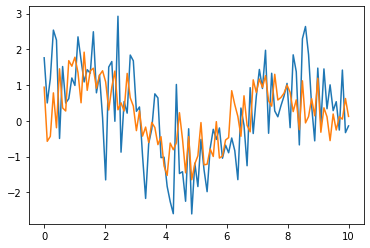

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
data_length = 100
n_sample = 100000
anomaly_noise = np.random.randn(data_length)    #異常値は分散が大きい
nomaly_noise  = np.random.randn(data_length)/2  #正常値は分散が小さい

#時系列とラベルを生成
t = np.linspace(0,10,data_length)
x_anomaly = np.array([np.sin(t) + anomaly_noise for i in range(n_sample//2)])
x_nomaly  = np.array([np.sin(t) + nomaly_noise  for i in range(n_sample//2)])
X = np.concatenate([x_anomaly,x_nomaly])
y = np.concatenate([np.ones(n_sample//2),np.zeros(n_sample//2)])

#シャッフル
rand_idx = np.arange(n_sample)
np.random.shuffle(rand_idx)
X = X[rand_idx,:]
y = y[rand_idx]

#描画
plt.plot(t,x_anomaly[0,:])
plt.plot(t,x_nomaly[0,:])
plt.show()

In [4]:
X_train2,X_test2,y_train2,y_test2 = train_test_split(X,y, random_state=0)
X_train2.shape, y_train2.shape

((75000, 100), (75000,))

In [5]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train2 = scaler.fit_transform(X_train2)
X_test2 = scaler.transform(X_test2)

### 【問題1】チャンネル数を1に限定した1次元畳み込み層クラスの作成
チャンネル数を1に限定した1次元畳み込み層のクラスSimpleConv1dを作成してください。基本構造は前のSprintで作成した全結合層のFCクラスと同じになります。なお、重みの初期化に関するクラスは必要に応じて作り変えてください。Xavierの初期値などを使う点は全結合層と同様です。

ここでは **パディング** は考えず、**ストライド** も1に固定します。また、複数のデータを同時に処理することも考えなくて良く、バッチサイズは1のみに対応してください。この部分の拡張はアドバンス課題とします。

フォワードプロパゲーションの数式は以下のようになります。
$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$

$a_i$  : 出力される配列のi番目の値

$F$ : フィルタのサイズ

$x_(i+s)$ : 入力の配列の(i+s)番目の値

$w_s$ : 重みの配列のs番目の値

$b$ : バイアス項

全てスカラーです。

次に更新式です。ここがAdaGradなどに置き換えられる点は全結合層と同様です。

$\alpha$ : 学習率

$\frac{\partial L}{\partial w_s}$ : $w_s$ に関する損失 $L$ の勾配

$\frac{\partial L}{\partial b}$ : $b$ に関する損失 $L$ の勾配

勾配 $\frac{\partial L}{\partial w_s}$ や $\frac{\partial L}{\partial b}$ を求めるためのバックプロパゲーションの数式が以下です。

$$
\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\\
\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}
$$

$\frac{\partial L}{\partial a_i}$ : 勾配の配列のi番目の値

$N_{out}$ : 出力のサイズ

前の層に流す誤差の数式は以下です。

$$
\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s
$$

$\frac{\partial L}{\partial x_j}$ : 前の層に流す誤差の配列のj番目の値

ただし、 $j-s<0$ または $j-s>N_{out}-1$ のとき $\frac{\partial L}{\partial a_{(j-s)}} =0$ です。

全結合層との大きな違いは、重みが複数の特徴量に対して共有されていることです。この場合は共有されている分の誤差を全て足すことで勾配を求めます。計算グラフ上での分岐はバックプロパゲーションの際に誤差の足し算をすれば良いことになります。

In [6]:
class SimpleConv1d:
    """
    チャンネル数を1に限定した1次元畳み込み層
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    input_channels : int
      入力のチャンネル数
    filter _sizes : int
      フィルタのサイズ
    stride_sizes : int
      スライドのサイズ
    output_channels : int
      出力のチャンネル数
    """
    def __init__(self, input_channels, filter_sizes, stride_sizes, initializer, optimizer):
        self.input_channels = input_channels
        self.filter_sizes = filter_sizes
        self.stride_sizes = stride_sizes
        self.optimizer = optimizer
        # 初期化
        if initializer is None:
            self.W = np.array([3, 5, 7])
            self.B = np.array([1])
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (input_channels, n_features)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (output_channels, filter_sizes-1)
            出力
        """        
        if self.stride_sizes == 1:
            A = np.convolve(X, self.W[::-1], mode='valid') + self.B
        return A
    
    def backward(self, dA, X):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Z : 次の形のndarray, shape (batch_size, n_nodes1)
            一層前の活性化関数の出力結果
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        #　前の層に流す誤差の計算
        dX = np.zeros(X.shape[0])
        diff = X.shape[0] - dA.shape[0]
        if diff > 0:
            dA_trans = np.concatenate([np.array([0]*diff), dA, np.array([0]*diff)], axis=0)
            # 重みの数
            w_num = self.W.shape[0]
            for i in range(X.shape[0]):
                dX[i] = np.dot(dA_trans[i: w_num+i], self.W[::-1])
            print(dX.shape, dX)
        
        # 更新
        self = self.optimizer.update(self, dA, X)
        return dX

- optimizer_class

In [7]:
class SGD_simple:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.1):
        self.lr = lr
    def update(self, layer, dA, X):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 後ろから流れてきた勾配
        """
        if len(dA.shape) == 1:
            # 各勾配の計算
            dB = np.convolve(dA, np.array([1]*dA.shape[0]), mode='valid')
            print(dB.shape, dB)
            
            dW = np.convolve(X, dA[::-1], mode='valid')
            print(dW.shape, dW)
            
            # バイアス、重みの更新
            layer.B = layer.B - dB * self.lr
            layer.W = layer.W - dW * self.lr

### 【問題2】1次元畳み込み後の出力サイズの計算
畳み込みを行うと特徴量の数が変化します。どのように変化するかは以下の数式から求められます。パディングやストライドも含めています。この計算を行う関数を作成してください。
$$
N_{out} =  \frac{N_{in}+2P-F}{S} + 1\\
$$

$N_{out}$ : 出力のサイズ（特徴量の数）

$N_{in}$ : 入力のサイズ（特徴量の数）

$P$ : ある方向へのパディングの数

$F$ : フィルタのサイズ

$S$ : ストライドのサイズ

In [8]:
def calc_output_nums(input_nums, paddings, filter_sizes, stride_sizes):
    output_nums = (input_nums + 2*paddings - filter_sizes) // stride_sizes + 1
    return output_nums

### 【問題3】小さな配列での1次元畳み込み層の実験
次に示す小さな配列でフォワードプロパゲーションとバックプロパゲーションが正しく行えているか確認してください。

入力x、重みw、バイアスbを次のようにします。

In [9]:
# x = np.array([1,2,3,4])
# w = np.array([3, 5, 7])
# b = np.array([1])

In [10]:
initializer=None
optimizer=SGD_simple()
input_channels =1
filter_sizes=3
stride_sizes = 1
simple_conv1d = SimpleConv1d(input_channels, filter_sizes, stride_sizes, initializer, optimizer)

In [11]:
simple_conv1d.W, simple_conv1d.B

(array([3, 5, 7]), array([1]))

フォワードプロパゲーションをすると出力は次のようになります。

In [12]:
# a = np.array([35, 50])

In [13]:
# フォワードプロぱゲーション
X = np.array([1, 2, 3, 4])
simple_conv1d.forward(X)

array([35, 50])

次にバックプロパゲーションを考えます。誤差は次のようであったとします。

In [14]:
# delta_a = np.array([10, 20])

バックプロパゲーションをすると次のような値になります。

In [15]:
# delta_b = np.array([30])
# delta_w = np.array([50, 80, 110])
# delta_x = np.array([30, 110, 170, 140])

In [16]:
# バックプロパゲーション 
dA = np.array([10, 20])
simple_conv1d.backward(dA, X)

(4,) [ 30. 110. 170. 140.]
(1,) [30]
(3,) [ 50  80 110]


array([ 30., 110., 170., 140.])

### 実装上の工夫
畳み込みを実装する場合は、まずはfor文を重ねていく形で構いません。しかし、できるだけ計算は効率化させたいため、以下の式を一度に計算する方法を考えることにします。
$$
a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b
$$
バイアス項は単純な足し算のため、重みの部分を見ます。
$$
\sum_{s=0}^{F-1}x_{(i+s)}w_s
$$
これは、xの一部を取り出した配列とwの配列の内積です。具体的な状況を考えると、以下のようなコードで計算できます。この例では流れを分かりやすくするために、各要素同士でアダマール積を計算してから合計を計算しています。これは結果的に内積と同様です。

In [17]:
# x = np.array([1, 2, 3, 4])
# w = np.array([3, 5, 7])
# a = np.empty((2, 3))
# indexes0 = np.array([0, 1, 2]).astype(np.int)
# indexes1 = np.array([1, 2, 3]).astype(np.int)
# a[0] = x[indexes0]*w # x[indexes0]は([1, 2, 3])である
# a[1] = x[indexes1]*w # x[indexes1]は([2, 3, 4])である
# a = a.sum(axis=1) # array([34., 49.,])

ndarrayは配列を使ったインデックス指定ができることを利用した方法です。

また、二次元配列を使えば一次元配列から二次元配列が取り出せます。

In [18]:
# x = np.array([1, 2, 3, 4])
# indexes = np.array([[0, 1, 2], [1, 2, 3]]).astype(np.int)
# print(x[indexes]) # ([[1, 2, 3], [2, 3, 4]])

このこととブロードキャストなどをうまく組み合わせることで、一度にまとめて計算することも可能です。

畳み込みの計算方法に正解はないので、自分なりに効率化していってください。

**《参考》**

以下のページのInteger array indexingの部分がこの方法についての記述です。

[Indexing — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)

### 【問題4】チャンネル数を限定しない1次元畳み込み層クラスの作成
チャンネル数を1に限定しない1次元畳み込み層のクラスConv1dを作成してください。

例えば以下のようなx, w, bがあった場合は、

In [19]:
# x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) # shape(2, 4)で、（入力チャンネル数、特徴量数）である。
# w = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
# b = np.array([1, 2, 3]) # （出力チャンネル数）

出力は次のようになります。

In [20]:
# a = np.array([[16, 22], [17, 23], [18, 24]]) # shape(3, 2)で、（出力チャンネル数、特徴量数）である。

入力が2チャンネル、出力が3チャンネルの例です。計算グラフを書いた上で、バックプロパゲーションも手計算で考えてみましょう。計算グラフの中には和と積しか登場しないので、微分を新たに考える必要はありません。

**《補足》**

チャンネル数を加える場合、配列をどういう順番にするかという問題があります。`(バッチサイズ、チャンネル数、特徴量数)`または`(バッチサイズ、特徴量数、チャンネル数)`が一般的で、ライブラリによって順番は異なっています。（切り替えて使用できるものもあります）

今回のスクラッチでは自身の実装上どちらが効率的かを考えて選んでください。上記の例ではバッチサイズは考えておらず、`(チャンネル数、特徴量数)`です。

- 以下作成ではバッチサイズを考慮して(バッチサイズ、チャンネル数、特徴量数)で実装

In [21]:
class Conv1d:
    """
    チャンネル数を限定しない1次元畳み込み層
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    batch_size : int
    input_channels : int
      入力のチャンネル数
    output_channels : int
      出力のチャンネル数
    filter _sizes : int
      フィルタのサイズ
    stride_sizes : int
      スライドのサイズ
    paddings : int
      ある方向へのパディングする数
    """
    
    def __init__(self, batch_size, input_channels, output_channels, filter_sizes, stride_sizes, paddings, initializer, optimizer):
        self.batch_size = batch_size
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.filter_sizes = filter_sizes
        self.stride_sizes = stride_sizes
        self.paddings = paddings
        self.optimizer = optimizer
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        if initializer is None:
            self.W = np.ones((self.output_channels, self.input_channels, self.filter_sizes))
            self.B = np.arange(1, self.output_channels+1)
        
        # self.W = initializer.W(input_channels, output_channels, strides)
        # self.B = initializer.B(output_channels)
        
            
    def calc_output_nums(self, input_nums, paddings, filter_sizes, stride_sizes):
        output_nums = (input_nums + 2*paddings - filter_sizes) // stride_sizes + 1
        return output_nums
    
    def zero_padding_1d(self, X):
        pad_width = [(0, 0) for _ in range(X.ndim-1)] + [(self.paddings, self.paddings)]
        return np.pad(X, pad_width, 'constant')
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, input_channels, input_nums)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, output_channels, output_nums)
            出力
        """
        # print('フォワードプロパゲーション')
        input_nums = X.shape[-1]
        # 出力する特徴量数を計算
        output_nums = self.calc_output_nums(input_nums, self.paddings, self.filter_sizes, self.stride_sizes)
        
        # パディングの処理、Xにゼロを追加する
        if self.paddings > 0:
            X = self.zero_padding_1d(X)
        
        # 畳み込みで計算するインデックスを計算
        indexes = np.array([[i for i in range(j * self.stride_sizes , self.filter_sizes + j * self.stride_sizes)] for j in range(output_nums)])
        
        # 畳み込みを実施
        calc = X[...,indexes][:, np.newaxis] * self.W[:, :, np.newaxis]
        A = calc.sum(axis=calc.ndim-1).sum(axis=calc.ndim-3) + self.B[:, np.newaxis]
        return A
    
    def backward(self, dA, X):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (self.output_channels, output_nums)
            後ろから流れてきた勾配
        X : 次の形のndarray, shape (self.batch_size, self.input_channles, input_nums)
            入力データ
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # print('バックプロパゲーション ')
        # dZを計算
        # 2はinput_channels, 4はfilter_sizes + N_out - 1    
        batch_size = X.shape[0]
        N_out = dA.shape[-1]
        N_in = self.stride_sizes * (N_out-1) - 2*self.paddings + self.filter_sizes
        dX = np.zeros((batch_size, self.input_channels, self.filter_sizes+N_out-1))
        # 重みを転置して、dAとの行列積をとり、再度転置
        calc = np.dot(self.W.T, dA).T
        # 2はN_out
        for i in range(N_out):
            dX[..., i:i+self.filter_sizes] += calc[i]
        dX = dX[..., 0:N_in]
        # 更新
        self = self.optimizer.update(self, dA, X)
        return dX

- optimizer

In [22]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.001):
        self.lr = lr
    def update(self, layer, dA, X):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 次の形のndarray, shape (self.batch_size, self.output_channels, output_nums)
            後ろから流れてきた勾配
        X : 次の形のndarray, shape (self.batch_size, self.input_channles, input_nums)
            入力データ
        """
        # 各勾配の計算
        
        # dAのbatch_size, N_outの軸に沿って合計する
        axis = dA.ndim-1
        dB = dA.sum(axis=axis).sum(axis=0)
        print('dB', dB.shape, dB)
        
        # 3　はfilter_size, 2は出力のサイズ(N_out)
        output_nums = dA.shape[-1]
        
        # パディングの処理？　行わないとXの形が変わっている
        if layer.paddings > 0:
            X = layer.zero_padding_1d(X)
        
        indexes = np.array([[i for i in range(j, layer.stride_sizes * output_nums + j, layer.stride_sizes)] for j in range(layer.filter_sizes)])        
        
        dW = np.dot(dA, X[..., indexes.T]).sum(axis=2).sum(axis=0)
        print('dW', dW.shape, dW)

        # バイアス、重みの更新
        layer.B = layer.B - dB * self.lr
        layer.W = layer.W - dW * self.lr

In [23]:
batch_size = 1
input_channels = 2
output_channels = 3
filter_sizes = 3
stride_sizes = 1
paddings = 0
initializer = None 
optimizer = SGD()
conv1d = Conv1d(batch_size, input_channels, output_channels, filter_sizes, stride_sizes, paddings, initializer, optimizer)

- 初期化した重みの確認

In [24]:
# インスタンス変数を呼び出す
conv1d.W, conv1d.B

(array([[[1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.]],
 
        [[1., 1., 1.],
         [1., 1., 1.]]]),
 array([1, 2, 3]))

#### フォワードプロパゲーション

$a_i = \sum_{s=0}^{F-1}x_{(i+s)}w_s+b$

In [25]:
X = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]])
# X = np.arange(32).reshape(batch_size, input_channels, 4)
local_X = deepcopy(X)
X.shape #　batch_size, input_channels, n_features

(1, 2, 4)

- 出力数の計算

In [26]:
input_nums = X.shape[-1]

In [27]:
# 問題２で作成した関数を呼び出す
N_out = calc_output_nums(input_nums=input_nums, paddings=paddings, filter_sizes=filter_sizes, stride_sizes=stride_sizes)
N_out

2

- 畳み込み計算するインデックスの取得し、最後の軸に沿ってXにインデックスを代入

In [28]:
indexes = np.array([[i for i in range(j, filter_sizes+j)] for j in range(N_out)])
indexes

array([[0, 1, 2],
       [1, 2, 3]])

In [29]:
print(local_X[...,indexes])
print(local_X[...,indexes].shape)
print('(batch_size, input_channels, N_out, filter_sizes)')

[[[[1 2 3]
   [2 3 4]]

  [[2 3 4]
   [3 4 5]]]]
(1, 2, 2, 3)
(batch_size, input_channels, N_out, filter_sizes)


- 畳み込み計算の実行

In [30]:
print(conv1d.W.shape)
print('(output_channels, input_channels, filter_sizes)')

(3, 2, 3)
(output_channels, input_channels, filter_sizes)


In [31]:
# 軸があるように、Xはbatchsizeの後に、Wのinput_channelsとfilter_sizesの間にaxisを追加してアダマール積をとる
print(local_X[...,indexes][:, np.newaxis] * conv1d.W[:, :, np.newaxis])
print((local_X[...,indexes][:, np.newaxis] * conv1d.W[:, :, np.newaxis]).shape)
print('(batch_size, output_channels, input_channels, N_out, filter_sizes)')

[[[[[1. 2. 3.]
    [2. 3. 4.]]

   [[2. 3. 4.]
    [3. 4. 5.]]]


  [[[1. 2. 3.]
    [2. 3. 4.]]

   [[2. 3. 4.]
    [3. 4. 5.]]]


  [[[1. 2. 3.]
    [2. 3. 4.]]

   [[2. 3. 4.]
    [3. 4. 5.]]]]]
(1, 3, 2, 2, 3)
(batch_size, output_channels, input_channels, N_out, filter_sizes)


- 畳み込み計算で残したい軸以外を合計し、バイアスを足す

In [32]:
calc = local_X[...,indexes][:, np.newaxis] * conv1d.W[:, :, np.newaxis]
A = calc.sum(axis=calc.ndim-1).sum(axis=calc.ndim-3) + conv1d.B[:, np.newaxis]
print(A)
print(A.shape)
print('(batch_size, output_channels, N_out)')

[[[16. 22.]
  [17. 23.]
  [18. 24.]]]
(1, 3, 2)
(batch_size, output_channels, N_out)


- 上記処理をクラスへ追加し、クラスオブジェクトで実行確認

In [33]:
# クラスオブジェクトで実行確認
A = conv1d.forward(X)
A

array([[[16., 22.],
        [17., 23.],
        [18., 24.]]])

#### バックプロパゲーション 

- dAはとりあえず上記で計算したAを使う

In [34]:
dA = A
print(dA)
print(dA.shape)
print('(batch_size, output_channels, N_out)')

[[[16. 22.]
  [17. 23.]
  [18. 24.]]]
(1, 3, 2)
(batch_size, output_channels, N_out)


- dBを計算

$\frac{\partial L}{\partial b} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}$

In [35]:
# dAのbatch_size, N_outの軸に沿って合計する
axis = dA.ndim-1
dB = dA.sum(axis=axis).sum(axis=0)
print(dB)
print(dB.shape)
print('(output_channels, )')

[38. 40. 42.]
(3,)
(output_channels, )


- dWを計算

$\frac{\partial L}{\partial w_s} = \sum_{i=0}^{N_{out}-1} \frac{\partial L}{\partial a_i}x_{(i+s)}\$

In [36]:
local_X, local_X.shape

(array([[[1, 2, 3, 4],
         [2, 3, 4, 5]]]),
 (1, 2, 4))

In [37]:
# 計算するためのインデックスを取得
indexes = np.array([[i for i in range(j, N_out+j)] for j in range(filter_sizes)])
print(indexes)
print(indexes.shape)
print('(filter_sizes, N_out)')

[[0 1]
 [1 2]
 [2 3]]
(3, 2)
(filter_sizes, N_out)


In [38]:
# dAとdot計算させるために、indexを転置してXの最後の軸に代入
print(local_X[..., indexes.T])
print((local_X[..., indexes.T]).shape)
print('(batch_size, input_channels, N_out, filter_sizes)')

[[[[1 2 3]
   [2 3 4]]

  [[2 3 4]
   [3 4 5]]]]
(1, 2, 2, 3)
(batch_size, input_channels, N_out, filter_sizes)


In [39]:
# dW　の計算
dW = np.dot(dA, local_X[..., indexes.T])
print(dW)
print(dW.shape)
print('(batch_size, output_channels, batch_size, input_channels, filter_sizes)')

[[[[[ 60.  98. 136.]
    [ 98. 136. 174.]]]


  [[[ 63. 103. 143.]
    [103. 143. 183.]]]


  [[[ 66. 108. 150.]
    [108. 150. 192.]]]]]
(1, 3, 1, 2, 3)
(batch_size, output_channels, batch_size, input_channels, filter_sizes)


In [40]:
dW.sum(axis=2).sum(axis=0), dW.sum(axis=2).sum(axis=0).shape

(array([[[ 60.,  98., 136.],
         [ 98., 136., 174.]],
 
        [[ 63., 103., 143.],
         [103., 143., 183.]],
 
        [[ 66., 108., 150.],
         [108., 150., 192.]]]),
 (3, 2, 3))

- dXを計算

$\frac{\partial L}{\partial x_j} = \sum_{s=0}^{F-1} \frac{\partial L}{\partial a_{(j-s)}}w_s$

In [41]:
# filtersは適当なW
filters = np.arange(output_channels*input_channels*filter_sizes).reshape(output_channels, input_channels, filter_sizes)
print(filters)
print(filters.shape)
print('output_channels, input_channels, filter_sizes')

[[[ 0  1  2]
  [ 3  4  5]]

 [[ 6  7  8]
  [ 9 10 11]]

 [[12 13 14]
  [15 16 17]]]
(3, 2, 3)
output_channels, input_channels, filter_sizes


In [42]:
print(dA)
print(dA.shape)
print('(batch_size, output_channels, N_out)')

[[[16. 22.]
  [17. 23.]
  [18. 24.]]]
(1, 3, 2)
(batch_size, output_channels, N_out)


In [43]:
filters.T, filters.T.shape

(array([[[ 0,  6, 12],
         [ 3,  9, 15]],
 
        [[ 1,  7, 13],
         [ 4, 10, 16]],
 
        [[ 2,  8, 14],
         [ 5, 11, 17]]]),
 (3, 2, 3))

In [44]:
calc = np.dot(filters.T, dA)
calc, calc.shape

(array([[[[318., 426.]],
 
         [[471., 633.]]],
 
 
        [[[369., 495.]],
 
         [[522., 702.]]],
 
 
        [[[420., 564.]],
 
         [[573., 771.]]]]),
 (3, 2, 1, 2))

In [45]:
calc = np.dot(filters.T, dA).T
calc, calc.shape

(array([[[[318., 369., 420.],
          [471., 522., 573.]]],
 
 
        [[[426., 495., 564.],
          [633., 702., 771.]]]]),
 (2, 1, 2, 3))

In [46]:
N_in = stride_sizes * (N_out-1) - 2*paddings + filter_sizes
N_in

4

In [47]:
# 2はinput_channels, 4はfilter_sizes + N_out - 1
dX = np.zeros((batch_size, input_channels, filter_sizes+N_out-1))
# 重みを転置して、dAとの行列積をとり、再度転置
calc = np.dot(filters.T, dA).T
# 2はN_out
for i in range(N_out):
    dX[..., i:i+filter_sizes] += calc[i]
dX = dX[..., 0:N_in]
dX, dX.shape

(array([[[ 318.,  795.,  915.,  564.],
         [ 471., 1155., 1275.,  771.]]]),
 (1, 2, 4))

In [48]:
# すべて１のWで再度dXを計算
# 2はinput_channels, 4はfilter_sizes + N_out - 1
dX = np.zeros((batch_size, input_channels, filter_sizes+N_out-1))
# 重みを転置して、dAとの行列積をとり、再度転置
calc = np.dot(conv1d.W.T, dA).T
# 2はN_out
for i in range(N_out):
    dX[..., i:i+filter_sizes] += calc[i]
dX = dX[..., 0:N_in]
dX, dX.shape

(array([[[ 51., 120., 120.,  69.],
         [ 51., 120., 120.,  69.]]]),
 (1, 2, 4))

- 上記処理をクラスへ追加し、クラスオブジェクトで実行確認

In [49]:
conv1d.backward(dA, X)

dB (3,) [38. 40. 42.]
dW (3, 2, 3) [[[ 60.  98. 136.]
  [ 98. 136. 174.]]

 [[ 63. 103. 143.]
  [103. 143. 183.]]

 [[ 66. 108. 150.]
  [108. 150. 192.]]]


array([[[ 51., 120., 120.,  69.],
        [ 51., 120., 120.,  69.]]])

### 【問題5】（アドバンス課題）パディングの実装

畳み込み層にパディングの機能を加えてください。1次元配列の場合、前後にn個特徴量を増やせるようにしてください。

最も単純なパディングは全て0で埋める **ゼロパディング** であり、CNNでは一般的です。他に端の値を繰り返す方法などもあります。

フレームワークによっては、元の入力のサイズを保つようにという指定をすることができます。この機能も持たせておくと便利です。なお、NumPyにはパディングの関数が存在します。

[numpy.pad — NumPy v1.17 Manual](https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html)

- パディングの処理

In [50]:
def zero_padding_1d(X, paddings):
    pad_width = [(0, 0) for _ in range(X.ndim-1)] + [(paddings, paddings)]
    return np.pad(X, pad_width, 'constant')

In [51]:
zero_padding_1d(X, paddings=1)

array([[[0, 1, 2, 3, 4, 0],
        [0, 2, 3, 4, 5, 0]]])

- 上のクラスにパディング処理を追加して、フォワードプロパゲーション、バックプロパゲーションを実行

In [52]:
batch_size = 1
input_channels = 2
output_channels = 3
filter_sizes = 3
stride_sizes = 1
paddings = 1
initializer = None 
optimizer = SGD()
conv1d = Conv1d(batch_size, input_channels, output_channels, filter_sizes, stride_sizes, paddings, initializer, optimizer)

In [53]:
A = conv1d.forward(X)
A

array([[[ 9., 16., 22., 17.],
        [10., 17., 23., 18.],
        [11., 18., 24., 19.]]])

In [54]:
dA = A
conv1d.backward(dA, X)

dB (3,) [64. 68. 72.]
dW (3, 2, 3) [[[111. 175. 154.]
  [166. 239. 201.]]

 [[117. 185. 163.]
  [175. 253. 213.]]

 [[123. 195. 172.]
  [184. 267. 225.]]]


array([[[ 30.,  81., 150., 174.],
        [ 30.,  81., 150., 174.]]])

### 【問題6】（アドバンス課題）ミニバッチへの対応
ここまでの課題はバッチサイズ1で良いとしてきました。しかし、実際は全結合層同様にミニバッチ学習が行われます。Conv1dクラスを複数のデータが同時に計算できるように変更してください。

- 上のクラスにバッチ数を変更できる処理を追加して、フォワードプロパゲーション、バックプロパゲーションを実行

In [55]:
batch_size = 5
input_channels = 2
output_channels = 3
filter_sizes = 3
stride_sizes = 1
paddings = 0
initializer = None 
optimizer = SGD()
conv1d = Conv1d(batch_size, input_channels, output_channels, filter_sizes, stride_sizes, paddings, initializer, optimizer)

In [56]:
batch5_X = np.arange(5*2*4).reshape(5, 2, 4)

In [57]:
A = conv1d.forward(batch5_X)
A

array([[[ 19.,  25.],
        [ 20.,  26.],
        [ 21.,  27.]],

       [[ 67.,  73.],
        [ 68.,  74.],
        [ 69.,  75.]],

       [[115., 121.],
        [116., 122.],
        [117., 123.]],

       [[163., 169.],
        [164., 170.],
        [165., 171.]],

       [[211., 217.],
        [212., 218.],
        [213., 219.]]])

In [58]:
dA = A
conv1d.backward(dA, batch5_X)

dB (3,) [1180. 1190. 1200.]
dW (3, 2, 3) [[[ 97425. 103325. 109225.]
  [121025. 126925. 132825.]]

 [[ 98250. 104200. 110150.]
  [122050. 128000. 133950.]]

 [[ 99075. 105075. 111075.]
  [123075. 129075. 135075.]]]


array([[[  60.,  138.,  138.,   78.],
        [  60.,  138.,  138.,   78.]],

       [[ 204.,  426.,  426.,  222.],
        [ 204.,  426.,  426.,  222.]],

       [[ 348.,  714.,  714.,  366.],
        [ 348.,  714.,  714.,  366.]],

       [[ 492., 1002., 1002.,  510.],
        [ 492., 1002., 1002.,  510.]],

       [[ 636., 1290., 1290.,  654.],
        [ 636., 1290., 1290.,  654.]]])

### 【問題7】（アドバンス課題）任意のストライド数
ストライドは1限定の実装をしてきましたが、任意のストライド数に対応できるようにしてください。

- 上記実装にて、フォワードプロパゲーション、バックプロパゲーションを行う際にインデックスを参照してきたが、そのインデックスの取得の仕方に任意のストライド数を加味してインデックスを取得できるように実装を変更

#### フォワードプロパゲーション

- 変更前

In [59]:
# indexes = np.array([[i for i in range(j, filter_sizes+j)] for j in range(N_out)])

- 変更後

In [60]:
# indexes = np.array([[i for i in range(j * stride_sizes, filter_sizes+(j * stride_sizes))] for j in range(N_out)])

#### バックプロパゲーション

- 変更前

In [61]:
# indexes = np.array([[i for i in range(j, N_out+j)] for j in range(filter_sizes)])

- 変更後

In [62]:
# indexes = np.array([[i for i in range(j, stride_sizes　*　N_out　+　j, stride_sizes)] for j in range(filter_sizes)])

- 上のクラスにストライド数を変更に対応する処理を追加して、フォワードプロパゲーション、バックプロパゲーションを実行

In [63]:
batch_size = 1
input_channels = 2
output_channels = 3
filter_sizes = 3
stride_sizes = 3
paddings = 1
initializer = None 
optimizer = SGD()
conv1d = Conv1d(batch_size, input_channels, output_channels, filter_sizes, stride_sizes, paddings, initializer, optimizer)

In [64]:
X = np.array([[[1, 2, 3, 4], [2, 3, 4, 5]]])

In [65]:
A = conv1d.forward(X)
A

array([[[ 9., 17.],
        [10., 18.],
        [11., 19.]]])

In [66]:
dA = A
conv1d.backward(dA, X)

dB (3,) [26. 28. 30.]
dW (3, 2, 3) [[[ 51.  77.  18.]
  [ 68. 103.  27.]]

 [[ 54.  82.  20.]
  [ 72. 110.  30.]]

 [[ 57.  87.  22.]
  [ 76. 117.  33.]]]


array([[[30., 84., 84., 54.],
        [30., 84., 84., 54.]]])

## 3.検証
### 【問題8】学習と推定
これまで使ってきたニューラルネットワークの全結合層の一部をConv1dに置き換えてMNISTを学習・推定し、Accuracyを計算してください。

出力層だけは全結合層をそのまま使ってください。ただし、チャンネルが複数ある状態では全結合層への入力は行えません。その段階でのチャンネルは1になるようにするか、 **平滑化** を行なってください。

画像に対しての1次元畳み込みは実用上は行わないことのため、精度は問いません。

- ミニバッチを取得するイテレータ

In [67]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

- Activation

In [68]:
class Sigmoid():
    def forward(self, A):
        Z = 1.0 / (1.0 + np.exp(-A))
        return Z
    def backward(self, A):
        # dZとアダマール計算する値
        return (1.0 - self.forward(A)) * self.forward(A)

class Tanh():
    def forward(self, A):
        Z = np.tanh(A)
        return Z
    
    def backward(self, A):
        # dZとアダマール計算する値
        return 1.0 - np.power(self.forward(A), 2)

class ReLU():
    def forward(self, A):
        Z = np.maximum(A, 0)
        return Z
    def backward(self, A):
        # dZとアダマール計算する値
        return np.where(A > 0, 1, 0)
    
class Softmax():
    def __init__(self, y_label_one_hot):
        # one_hot_encodingされた正解ラベル
        self.y_label_one_hot = y_label_one_hot

    def forward(self, A):
        # オーバーフローを防ぐ
        A -= np.max(A)
        # Z = np.exp(A) / np.exp(A).sum(axis=1)[:, np.newaxis]
        Z = np.exp(A) / np.exp(A).sum(axis=2)[..., np.newaxis]
        return Z

    def _cross_entropy_error(self, A):
        # return -(np.log(self.forward(A)) * self.y_label_one_hot).sum(axis=1).mean()
        error = -(np.log(self.forward(A).sum(axis=1)) * self.y_label_one_hot).sum(axis=1).mean() 
        return error

    def backward(self, A):
        # 交差エントロピー誤差の計算
        loss = self._cross_entropy_error(A)
        # dA　の計算
        # dA = self.forward(A) - self.y_label_one_hot
        dA = self.forward(A) - self.y_label_one_hot[:, np.newaxis]
        # dA, loss
        return dA, loss

- 畳み込み層

In [69]:
class Conv1d:
    """
    チャンネル数を限定しない1次元畳み込み層
    Parameters
    ----------
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    # batch_size : int
    input_channels : int
      入力のチャンネル数
    output_channels : int
      出力のチャンネル数
    filter _sizes : int
      フィルタのサイズ
    stride_sizes : int
      スライドのサイズ
    paddings : int
      ある方向へのパディングする数
    """
    
    def __init__(self, input_channels, output_channels, filter_sizes, stride_sizes, paddings, initializer, optimizer):
        # self.batch_size = batch_size
        self.input_channels = input_channels
        self.output_channels = output_channels
        self.filter_sizes = filter_sizes
        self.stride_sizes = stride_sizes
        self.paddings = paddings
        self.optimizer = optimizer
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        if initializer is None:
            self.W = np.ones((self.output_channels, self.input_channels, self.filter_sizes))
            self.B = np.arange(1, self.output_channels+1)
        else:
            self.W = initializer.W(self.output_channels, self.input_channels, self.filter_sizes)
            self.B = initializer.B(self.output_channels)
        
            
    def calc_output_nums(self, input_nums, paddings, filter_sizes, stride_sizes):
        output_nums = (input_nums + 2*paddings - filter_sizes) // stride_sizes + 1
        return output_nums
    
    def zero_padding_1d(self, X):
        pad_width = [(0, 0) for _ in range(X.ndim-1)] + [(self.paddings, self.paddings)]
        return np.pad(X, pad_width, 'constant')
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, input_channels, input_nums)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, output_channels, output_nums)
            出力
        """
        # print('フォワードプロパゲーション')
        input_nums = X.shape[-1]
        # 出力する特徴量数を計算
        output_nums = self.calc_output_nums(input_nums, self.paddings, self.filter_sizes, self.stride_sizes)
        
        # パディングの処理、Xにゼロを追加する
        if self.paddings > 0:
            X = self.zero_padding_1d(X)
        
        # 畳み込みで計算するインデックスを計算
        indexes = np.array([[i for i in range(j * self.stride_sizes , self.filter_sizes + j * self.stride_sizes)] for j in range(output_nums)])
        
        # 畳み込みを実施
        calc = X[...,indexes][:, np.newaxis] * self.W[:, :, np.newaxis]
        A = calc.sum(axis=calc.ndim-1).sum(axis=calc.ndim-3) + self.B[:, np.newaxis]
        return A
    
    def backward(self, dA, X):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (self.output_channels, output_nums)
            後ろから流れてきた勾配
        X : 次の形のndarray, shape (batch_size, self.input_channles, input_nums)
            入力データ
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        # print('バックプロパゲーション ')
        # dZを計算
        # 2はinput_channels, 4はfilter_sizes + N_out - 1
#         N_out = dA.shape[-1]
#         dX = np.zeros((X.shape[0], self.input_channels, self.filter_sizes+N_out-1))
#         # 重みを転置して、dAとの行列積をとり、再度転置
#         calc = np.dot(self.W.T, dA).T
#         # 2はN_out
#         for i in range(N_out):
#             dX[..., i:i+self.filter_sizes] += calc[i]

#         # 更新
#         self = self.optimizer.update(self, dA, X)
#         return dX
 
        batch_size = X.shape[0]
        N_out = dA.shape[-1]
        N_in = self.stride_sizes * (N_out-1) - 2*self.paddings + self.filter_sizes
        dX = np.zeros((batch_size, self.input_channels, self.filter_sizes+N_out-1))
        # 重みを転置して、dAとの行列積をとり、再度転置
        calc = np.dot(self.W.T, dA).T
        # 2はN_out
        for i in range(N_out):
            dX[..., i:i+self.filter_sizes] += calc[i]
        dX = dX[..., 0:N_in]
        # 更新
        self = self.optimizer.update(self, dA, X)
        return dX

- 平滑化

In [70]:
class Flatten:
    """
    平滑化する処理
    forwardのshape
        self.forward(X) X: (batch_size, input_channels, output_nums)
        return flat_X : (batch_size, input_channels * output_nums)
    backwardのshape
        self.backward(dX) dX: (batch_size, input_channels * output_nums)
        return original_dX : (batch_size, input_channels, output_nums)
    """
    def __init__(self):
        self.shape = None
    def forward(self, X):
        self.shape = X.shape
        flat_X = X.reshape(self.shape[0], np.prod(self.shape[1:]))
        return flat_X
    def backward(self, dX):
        original_dX = dX.reshape(self.shape)
        return original_dX

- initialiver

In [71]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma=0.01):
        self.sigma = sigma
    def W(self, output_channels, input_channels, filter_sizes):
        """
        重みの初期化
        Parameters
        ----------
        output_channels : int 出力チャネル数
        input_channels : int 入力チャネル数
        filter_sizes : int フィルター数
        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(output_channels, input_channels, filter_sizes)
        return W
    def B(self, output_channels):
        """
        バイアスの初期化
        Parameters
        ----------
        output_channels : int 出力チャネル数
        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(output_channels)
        return B

In [72]:
class XavierInitializer:
    """
    Xavierによる初期化
    Parameters
    ----------
    前の層のノード数の逆数の平方根を標準偏差とする分布
    """
    def W(self, output_channels, input_channels, filter_sizes):
        """
        重みの初期化
        Parameters
        ----------
        output_channels : int 出力チャネル数
        input_channels : int 入力チャネル数
        filter_sizes : int フィルター数
        Returns
        ----------
        W :
        """
        W = np.sqrt(1 / input_channels) * np.random.randn(output_channels, input_channels, filter_sizes)
        return W
        
    def B(self, output_channels):
        """
        バイアスの初期化
        Parameters
        ----------
        output_channels : int 出力チャネル数
        Returns
        ----------
        B :
        """
        B = np.zeros(output_channels)
        return B

In [73]:
class HeInitializer:
    """
    Heによる初期化
    Parameters
    ----------
    前の層のノード数の逆数を２倍した平方根を標準偏差とする分布
    """
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        output_channels : int 出力チャネル数
        input_channels : int 入力チャネル数
        filter_sizes : int フィルター数
        Returns
        ----------
        W :
        """
        W = np.sqrt(2 / input_channels) * np.random.randn(output_channels, input_channels, filter_sizes)
        return W
    
    def B(self, output_channels):
        """
        バイアスの初期化
        Parameters
        ----------
        output_channels : int 出力チャネル数
        Returns
        ----------
        B :
        """
        B = np.zeros(output_channels)
        return B

- optimizer

In [74]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.001):
        self.lr = lr
    def update(self, layer, dA, X):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 次の形のndarray, shape (batch_size, self.output_channels, output_nums)
            後ろから流れてきた勾配
        X : 次の形のndarray, shape (batch_size, self.input_channles, input_nums)
            入力データ
        """
        # 各勾配の計算
        # dAのbatch_size, N_outの軸に沿って合計する
        axis = dA.ndim-1
        dB = dA.sum(axis=axis).sum(axis=0)
        # print('dB', dB.shape, dB)
        
        # 3　はfilter_size, 2は出力のサイズ(N_out)
        output_nums = dA.shape[-1]
        
        # パディングの処理？　行わないとXの形が変わっている
        if layer.paddings > 0:
            X = layer.zero_padding_1d(X)
        
        indexes = np.array([[i for i in range(j, layer.stride_sizes * output_nums + j, layer.stride_sizes)] for j in range(layer.filter_sizes)])        
        
        dW = np.dot(dA, X[..., indexes.T]).sum(axis=2).sum(axis=0)
        # print('dW', dW.shape, dW)

        # バイアス、重みの更新
        layer.B = layer.B - dB * self.lr
        layer.W = layer.W - dW * self.lr

In [75]:
class AdaGrad:
    """
    更新された分だけ、その重みに対する学習率を下げていく
    Parameters
    --------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer, dA, X):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        dA : 次の形のndarray, shape (batch_size, self.output_channels, output_nums)
            後ろから流れてきた勾配
        X : 次の形のndarray, shape (batch_size, self.input_channles, input_nums)
            入力データ
        H_B, H_W : class_FCで初期値1で作成
        """
        # 各勾配の計算
        # dAのbatch_size, N_outの軸に沿って合計する
        axis = dA.ndim-1
        dB = dA.sum(axis=axis).sum(axis=0)
        layer.H_B += np.power(dB, 2)
        
        # 3　はfilter_size, 2は出力のサイズ(N_out)
        output_nums = dA.shape[-1]
        
        # パディングの処理？　行わないとXの形が変わっている
        if layer.paddings > 0:
            X = layer.zero_padding_1d(X)
        
        indexes = np.array([[i for i in range(j, layer.stride_sizes * output_nums + j, layer.stride_sizes)] for j in range(layer.filter_sizes)])        
        
        dW = np.dot(dA, X[..., indexes.T]).sum(axis=2).sum(axis=0)
        layer.H_W += np.power(dW, 2)

        # バイアス、重みの更新
        layer.B = layer.B - dB * self.lr / np.sqrt(layer.H_B)
        layer.W = layer.W - dW * self.lr / np.sqrt(layer.H_W)

- 1次元の畳み込みニューラルネットワーク分類器

In [76]:
from copy import deepcopy
import numpy as np
class ScratchCNN1dNeuralNetworkClassifier():
    """
    多層な1次元の畳み込みニューラルネットワーク分類器
    Parameters
    ----------
    Attributes
    ----------
    """
    def __init__(self, activation='relu', verbose=False, random_state=None, epoch=10, batch_size=20, lr=0.001, hidden_layer_sizes=((1, 10),(1, 10)), stride_sizes=1, paddings=0, initialize=None, sigma=None, optimize=None):
        self.verbose = verbose
        # 学習率
        self.lr = lr
        # 各層のアウトプットチャネル数、フィルタサイズを記録
        self.hidden_layer_sizes = hidden_layer_sizes
        # ストライドのサイズ
        self.stride_sizes = stride_sizes
        # パディングの数
        self.paddings = paddings
        # バッチサイズ
        self.batch_size = batch_size
        # epochの回数
        self.epoch = epoch
        # 活性化関数の名前　'sigmoid', 'tanh', 'relu'
        self.activation = activation
        # 乱数の設定
        self.random_state = random_state
        # 初期値の設定方法 'gauss', 'xavier', 'he'
        self.initialize = initialize
        # 初期値をガウス分布で定める際の標準偏差
        self.sigma = sigma
        # 最適化手法 'sgd', 'adagrad'
        self.optimize = optimize
        
        # 出力クラス数
        self.n_output = None
        # 出力カテゴリの配列
        self.categories_ = None
        # 重みの情報リスト
        # self.coefs_ = None
        # self.intercepts_ = None
        # epoch毎に損失を記録
        self.losses = np.zeros(self.epoch)
        self.val_losses = None
        # fitの時にvalデータがあるフラグ
        self.val_flag = None    

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。
        
        Parameters
        ----------
        X_train : 次の形のndarray, shape (n_samples, ..., n_features)
            訓練データの特徴量
        y_train : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, ..., n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # random_stateが設定されている場合はseed設定
        if type(self.random_state) == int:
            np.random.seed(self.random_state)
        # 特徴量データがinput_channels１で, ndimが２の時、input_channelsの次元を追加
        if X_train.ndim == 2:
            X_train = X_train[:, np.newaxis]
            X_val = X_val[:, np.newaxis]
        
        # 変数情報
        self.n_samples, input_channels, self.n_features = X_train.shape
        # valデータの確認
        if type(X_val) == np.ndarray and type(y_val) == np.ndarray:
            if X_val.shape == (y_val.shape[0], input_channels, self.n_features):
                self.val_flag = True
                self.val_losses = np.zeros(self.epoch)
        
        # 目的変数をone_hot_encoding
        from sklearn.preprocessing import OneHotEncoder
        enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
        y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
        if self.val_flag:
            y_val_one_hot = enc.transform(y_val[:, np.newaxis])
        
        # 出力カテゴリの配列
        self.categories_ = enc.categories_[0]
        # 出力クラス数を特定
        self.n_output = len(self.categories_)
        
        # 初期化のインスタンス作成
        # initializeで指定がない時、sigmoid, tanhではxavier, reluではhe
        if self.initialize is None:
            if self.activation == 'relu':
                self.initialize = 'he'
            elif self.activation == 'sigmoid' or self.activation == 'tanh':
                self.initialize = 'xavier'
        # self.initializeに応じてinitializerのインスタンスを作成
        if self.initialize == 'he':
            initializer = HeInitializer()
        elif self.initialize == 'xavier':
            initializer = XavierInitializer()
        elif self.initialize == 'gauss':
            if self.sigma is None:
                self.sigma = 0.01
            initializer = SimpleInitializer(self.sigma)
        
        # 最適化のインスタンス作成
        if self.optimize == 'adagrad':
            optimizer = AdaGrad(self.lr)
        elif self.optimize == 'sgd':
            optimizer = SGD(self.lr)
        
        # 重みを初期化し、インスタンスをリストへ
        self.conv1d_lst = []
        input_nums = self.n_features
        for output_channels, filter_sizes in self.hidden_layer_sizes:
            conv1d = Conv1d(input_channels=input_channels, output_channels=output_channels, filter_sizes=filter_sizes, stride_sizes=self.stride_sizes, paddings=self.paddings, initializer=initializer, optimizer=optimizer)
            input_nums = conv1d.calc_output_nums(input_nums, self.paddings, filter_sizes, self.stride_sizes)
            # self.optimize　が 'adagrad' の際、インスタンスへH_W, H_Bを持たせる
            if self.optimize == 'adagrad':
                conv1d.adagrad_initialize(row, n_nodes)
            self.conv1d_lst.append(conv1d)
            input_channels = output_channels
        #　最後の出力がn_outputと同じ数になるようにフィルタサイズを調整
        filter_sizes = input_nums + self.paddings*2 + self.stride_sizes*(1-self.n_output)

        conv1d = Conv1d(input_channels=input_channels, output_channels=1, filter_sizes=filter_sizes, stride_sizes=self.stride_sizes, paddings=self.paddings, initializer=initializer, optimizer=optimizer)
        # self.optimize　が 'adagrad' の際、インスタンスへH_W, H_Bを持たせる
        if self.optimize == 'adagrad':
            conv1d.adagrad_initialize(row, n_nodes)
        self.conv1d_lst.append(conv1d)
        
        # 活性化関数のインスタンス
        if self.activation == 'relu':
            self.act = ReLU()
        elif self.activation == 'sigmoid':
            self.act = Sigmoid()
        elif self.activation == 'tanh':
            self.act = Tanh()
        else:
            print('not proper activation name')
        
        # epoch　でループ
        for n_epoch in range(self.epoch):
            # 各々のバッチの損失の記録
            batches_losses = np.zeros(int(np.ceil(self.n_samples / self.batch_size)), dtype=np.float64)
            if self.val_flag:
                batches_val_losses = np.zeros(int(np.ceil(self.n_samples / self.batch_size)), dtype=np.float64)
            
            # バッチを取り出し、バッチでループ
            get_mini_batch = GetMiniBatch(X_train, y_train_one_hot, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:
                
                # forward propagation
                # 全結合層の結果をリストで管理、ex [0, A_1, A_2]
                A_lst = [0]
                # 、活性化の結果をリストで管理、ex [X, Z_1, Z_2]
                Z_lst = [mini_X_train]
                Z = mini_X_train
                
                # 各層をループ
                for i in range(len(self.hidden_layer_sizes)):
                    
                    A = self.conv1d_lst[i].forward(Z)
                    # actでZを計算
                    Z = self.act.forward(A)
                    
                    # A, Z　をdeepcopyしてリストへ保管　（deepcopy必要？）
                    A_lst.append(deepcopy(A))
                    Z_lst.append(deepcopy(Z))
                
                # 最後の出力層、forward_propagation
                # 最終層の活性化関数のインスタンス
                self.last_act = Softmax(mini_y_train)
                A = self.conv1d_lst[i+1].forward(Z)
                Z = self.last_act.forward(A)

                # 最後の出力層、back_propagation
                # 最終層のAをもとに、dA　と　損失を求める（損失は記録）
                dA, batches_losses[get_mini_batch._counter-1] = self.last_act.backward(A)
                
                # val_flag　Trueの場合は同じ処理を行う
                if self.val_flag:
                    Z_val = X_val
                    # 各層をループ
                    for i in range(len(self.hidden_layer_sizes)):
                        A_val = self.conv1d_lst[i].forward(Z_val)
                        Z_val = self.act.forward(A_val)
                    # 最終層の活性化関数のインスタンス
                    last_act_val = Softmax(y_val_one_hot)
                    A_val = self.conv1d_lst[i+1].forward(Z_val)
                    Z_val = last_act_val.forward(A_val) 
                    # 最後の出力層、back_propagation
                    # 最終層のAをもとに、dA　と　損失を求める（損失は記録）
                    _, batches_val_losses[get_mini_batch._counter-1] = last_act_val.backward(A_val)
                    
                # back propagation
                # fc, A, Zを逆順で取り出す
                for conv1d, A, Z in zip(self.conv1d_lst[::-1], A_lst[::-1], Z_lst[::-1]):
                    # dZ の勾配を求める、関数内でW、Bを更新
                    dZ = conv1d.backward(dA, Z)
                    # dAを求める、dZ　と　活性化関数のアダマール積、最後のdAはゼロになる
                    dA = dZ * self.act.backward(A)
  
            #　バッチのループが終わったら損失を合計し、記録
            self.losses[n_epoch] = batches_losses.sum()
            if self.val_flag:
                self.val_losses[n_epoch] = batches_val_losses.sum()
        
            #verboseをTrueにした際は学習過程などを出力する
            if self.verbose is True:
                print('epoch : {} finished'.format(n_epoch))
                print('train_loss : {}'.format(self.losses[n_epoch]))
                if self.val_flag:
                    print('val_loss : {}'.format(self.val_losses[n_epoch]))
        
        # 学習が終わったら重み、バイアスを変数へ記録
#         self.coefs_ = [fc.W for fc in fc_lst]
#         self.intercepts_ = [fc.B for fc in fc_lst]
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # 特徴量データがinput_channels１で, ndimが２の時、input_channelsの次元を追加
        if X.ndim == 2:
            X = X[:, np.newaxis]
        
        # 活性化関数の出力結果をpredで管理
        pred = X

        # 各層をループ
        for conv1d in self.conv1d_lst[:-1]:
            input_nums = pred.shape[-1]
            output_nums = conv1d.calc_output_nums(input_nums, conv1d.paddings, conv1d.filter_sizes, conv1d.stride_sizes)
            
            # パディングの処理、Xにゼロを追加する
            if conv1d.paddings > 0:
                pred = conv1d.zero_padding_1d(pred)
        
            # 畳み込みで計算するインデックスを計算
            indexes = np.array([[i for i in range(j * conv1d.stride_sizes , conv1d.filter_sizes + j * conv1d.stride_sizes)] for j in range(output_nums)])
            
            # 畳み込みを実施
            calc = pred[...,indexes][:, np.newaxis] * conv1d.W[:, :, np.newaxis]
            A = calc.sum(axis=calc.ndim-1).sum(axis=calc.ndim-3) + conv1d.B[:, np.newaxis]
        
            pred = self.act.forward(A)
        
        # 最後の出力層
        conv1d = self.conv1d_lst[-1]
        input_nums = pred.shape[-1]
        output_nums = conv1d.calc_output_nums(input_nums, conv1d.paddings, conv1d.filter_sizes, conv1d.stride_sizes)
            
        # パディングの処理、Xにゼロを追加する
        if conv1d.paddings > 0:
            pred = conv1d.zero_padding_1d(pred)
        
        # 畳み込みで計算するインデックスを計算
        indexes = np.array([[i for i in range(j * conv1d.stride_sizes , conv1d.filter_sizes + j * conv1d.stride_sizes)] for j in range(output_nums)])
            
        # 畳み込みを実施
        calc = pred[...,indexes][:, np.newaxis] * conv1d.W[:, :, np.newaxis]
        A = calc.sum(axis=calc.ndim-1).sum(axis=calc.ndim-3) + conv1d.B[:, np.newaxis]
        
        # 最後の活性化関数
        pred = self.last_act.forward(A)
        # input_channelsを消すためにaxis=1で合計
        pred = pred.sum(axis=1)

        # 列、横方向に最大のインデックスを取得し、出力カテゴリのself.categories_の値を返す
        return self.categories_[np.argmax(pred, axis=1)]

- 検証結果をアウトプットする関数

In [77]:
# 設定しているパラメーターの表示
def display_params(clf):
    parameters = deepcopy(vars(clf))
    delete_params = ['verbose', 'n_output', 'categories_', 'coefs_', 'intercepts_', 'losses', 'val_losses', 'val_flag', 'n_samples', 'n_features', 'act', 'last_act']
    for params in delete_params:
        del parameters[params]
    print('Paremeters : ')
    print(parameters)
    return parameters

In [78]:
# Accuracy_scoreの計算
from sklearn.metrics import accuracy_score
def acc_score(X_test, y_test, clf):
    score = accuracy_score(y_test, clf.predict(X_test))
    print('Accuracy_score : {}'.format(score))
    return score

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline
# 損失関数のプロット
def loss_plot(clf):
    plt.plot(range(clf.epoch), clf.losses, label='train_loss')
    if clf.val_flag:
        plt.plot(range(clf.epoch), clf.val_losses, label='val_loss')
    plt.xlabel('n_epoch')
    plt.title('model_loss')
    plt.legend()
    plt.show()

In [80]:
# MNISTデータの誤分類結果を表示する
def miss_class_imshow(y_pred, y_val, X_val, num, n_columns = 6):
    """
    誤分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

    Parameters:
    ----------
    y_pred : 推定値のndarray (n_samples,)
    y_val : 検証データの正解ラベル(n_samples,)
    X_val : 検証データの特徴量（n_samples, n_features)
    num : 表示する数
    n_columns : 表示する列数
    """
    import numpy as np
    import matplotlib.pyplot as plt
    true_false = y_pred==y_val
    false_list = np.where(true_false==False)[0].astype(np.int)
    if false_list.shape[0] < num:
        num = false_list.shape[0]
    fig = plt.figure(figsize=(16, (num-1//n_columns + 1)*(16 / n_columns)))
    fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
    for i in range(num):
        ax = fig.add_subplot(num-1//n_columns + 1, n_columns, i + 1, xticks=[], yticks=[])
        ax.set_title("pred:{} / ans:{}".format(y_pred[false_list[i]],y_val[false_list[i]]))
        ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')

In [81]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
X, y = make_classification(n_samples=1000, random_state=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, stratify=y,random_state=1)

In [82]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
X_train3 = scaler.fit_transform(X_train3)
X_test3 = scaler.transform(X_test3)

In [89]:
start = time.time()
cnn1d = ScratchCNN1dNeuralNetworkClassifier(activation='relu', verbose=False,
                                            random_state=0, epoch=20, lr=0.001,
                                            hidden_layer_sizes=((1,10),(1, 10)),stride_sizes=1,
                                            paddings=0, initialize='xavier',sigma=0.001, optimize='sgd')
cnn1d.fit(X_train3, y_train3, X_test3, y_test3)
print("time : {:,.1f}[s]".format(time.time() - start))

time : 1.1[s]


Accuracy_score : 0.636


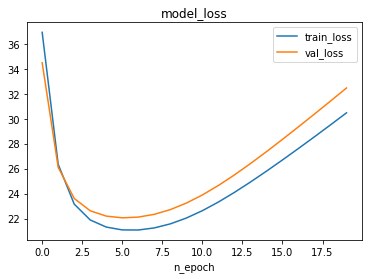

In [90]:
acc = acc_score(X_test3, y_test3, cnn1d)
loss_plot(cnn1d)

In [85]:
# start = time.time()
# cnn1d = ScratchCNN1dNeuralNetworkClassifier(activation='relu', verbose=False,
#                                             random_state=0, epoch=5, lr=0.001,
#                                             hidden_layer_sizes=((1, 10),(1, 10)),stride_sizes=1,
#                                             paddings=0, initialize='xavier',sigma=0.001, optimize='sgd')
# cnn1d.fit(X_train2, y_train2, X_test2, y_test2)
# print("time : {:,.1f}[s]".format(time.time() - start))

In [86]:
# acc = acc_score(X_test2, y_test2, cnn1d)
# loss_plot(cnn1d)